In [4]:
import numpy as np
import matplotlib.pyplot as plt

def monotone_nearest_path(x, y, allow_equal_y=True, max_dx=None, max_dist=None):
    x = np.asarray(x); y = np.asarray(y)
    idx = np.argsort(x)                 # ÂÖàÊåâ x ÊéíÂ∫è
    xs, ys = x[idx], y[idx]

    path_idx = [0]                      # ‰ªéÊúÄÂ∑¶ÁÇπÂºÄÂßã
    curr = 0

    while True:
        x0, y0 = xs[curr], ys[curr]

        # ÂÄôÈÄâÔºöÂú®Âè≥‰æß„ÄÅ‰∏î‰∏ç‰∏ãÈôç
        j = np.arange(curr+1, len(xs))
        mask = (xs[j] > x0)
        if allow_equal_y:
            mask &= (ys[j] >= y0)
        else:
            mask &= (ys[j] > y0)

        if max_dx is not None:
            mask &= (xs[j] - x0) <= max_dx

        cand = j[mask]
        if cand.size == 0:
            break

        dx = xs[cand] - x0
        dy = ys[cand] - y0
        dist = np.hypot(dx, dy)

        if max_dist is not None:
            ok = dist <= max_dist
            cand, dist = cand[ok], dist[ok]
            if cand.size == 0:
                break

        # ÈÄâË∑ùÁ¶ªÊúÄÂ∞èÁöÑ
        next_j = cand[np.argmin(dist)]

        path_idx.append(next_j)
        curr = next_j

    return xs[path_idx], ys[path_idx], idx[path_idx]

In [5]:
import numpy as np
import pwlf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

input_file = "../input_file/phpunit.csv" #Input data 

df_composer = pd.read_csv(input_file)
# Prepare the data for pwlf
x = df_composer['accumulative_raw'].values
y = df_composer['complexity_raw'].values

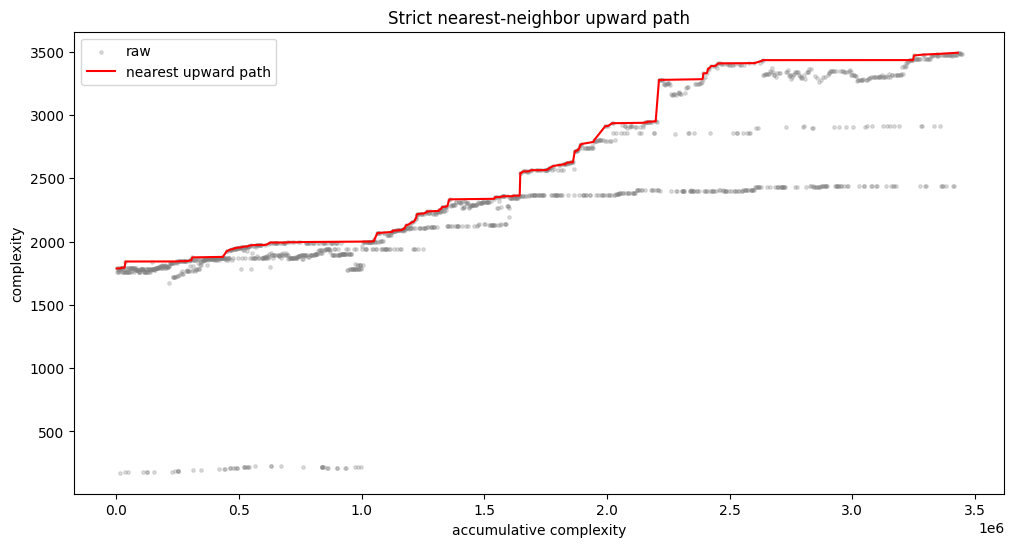

In [6]:
# ===== ‰ΩøÁî®Á§∫‰æã =====
x_path, y_path, _ = monotone_nearest_path(x, y)

plt.figure(figsize=(12,6))
# ÂéüÂßãÁÅ∞Ëâ≤Êï£ÁÇπ
idx = np.argsort(x)
plt.scatter(np.array(x)[idx], np.array(y)[idx], s=6, alpha=0.25, color='gray', label='raw')

# ÈÄâÂá∫ÁöÑË∑ØÂæÑÁîªÊàêÁ∫¢Á∫ø
plt.plot(x_path, y_path, lw=1.5, color='red', label='nearest upward path')

plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.title('Strict nearest-neighbor upward path')
plt.legend()
plt.show()

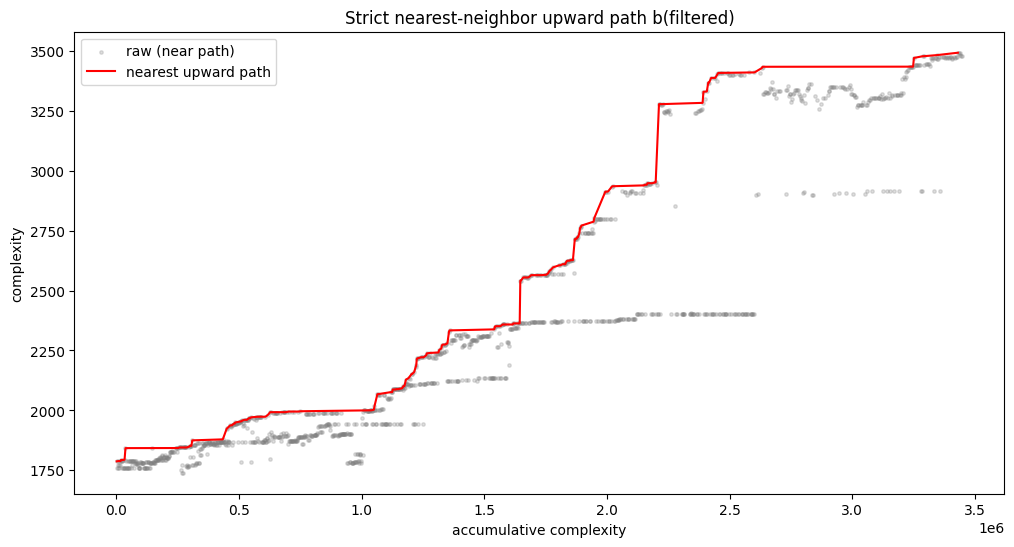

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ÂÅáËÆæ‰Ω†Â∑≤Êúâ x, y, x_path, y_path
idx = np.argsort(x)

# ÂÆö‰πâÂÆπÂøçÂ∫¶ÔºåÊØîÂ¶Ç 50ÔºàÊï∞ÂÄºÂèØË∞ÉËäÇÔºåË∂äÂ∞èË∂äË¥¥ËøëË∑ØÂæÑÔºâ
tolerance = 50  

# ËÆ°ÁÆóÊØè‰∏™ÁÇπÂà∞Ë∑ØÂæÑÁöÑÊúÄÂ∞èË∑ùÁ¶ªÔºàÂú® y Áª¥Â∫¶‰∏äÔºâ
# np.abs(y_i - y_path) ÂæóÂà∞Áü©ÈòµÔºåÁÑ∂ÂêéÂèñÊúÄÂ∞èÂÄº
distances = np.min(np.abs(np.array(y)[:, None] - y_path), axis=1)

# Âè™‰øùÁïôË∑ùÁ¶ªË∑ØÂæÑÂ∞è‰∫éÂÆπÂøçÂ∫¶ÁöÑÁÇπ
mask = distances < tolerance

plt.figure(figsize=(12,6))
plt.scatter(np.array(x)[idx][mask[idx]], np.array(y)[idx][mask[idx]], 
            s=6, alpha=0.25, color='gray', label='raw (near path)')

# ÁîªË∑ØÂæÑ
plt.plot(x_path, y_path, lw=1.5, color='red', label='nearest upward path')

plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.title('Strict nearest-neighbor upward path b(filtered)')
plt.legend()
plt.show()


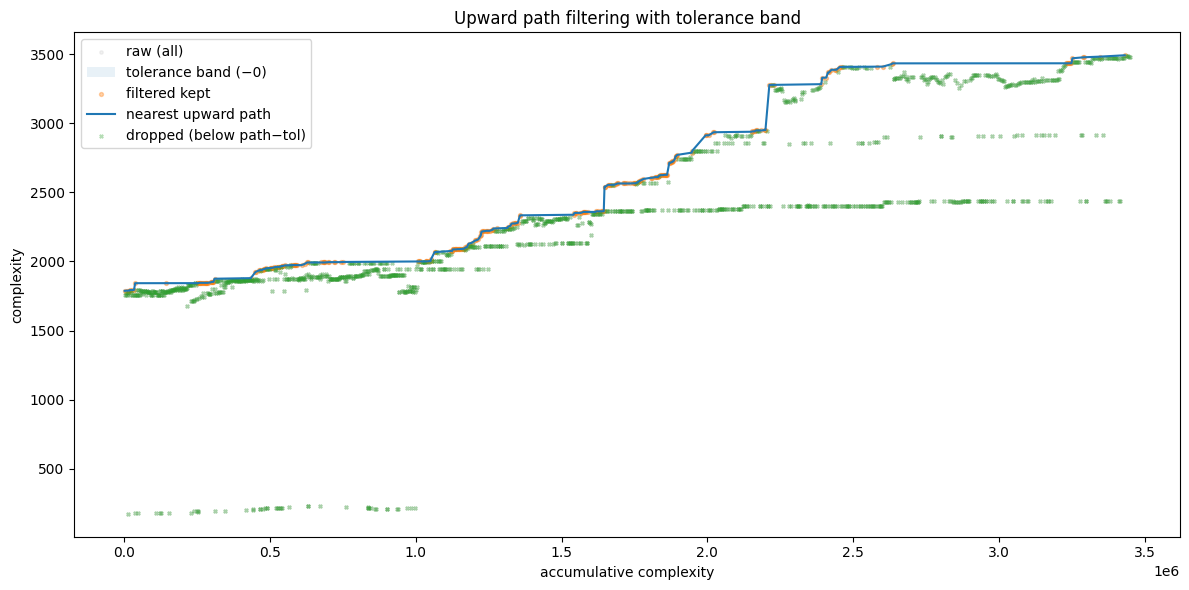

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ---- ÂÆâÂÖ®ËΩ¨Êç¢ & ÊéíÂ∫èÔºàÂæàÈáçË¶ÅÔºönp.interp ÈúÄË¶ÅÂçïË∞ÉÈÄíÂ¢ûÁöÑ xÔºâ----
x = np.asarray(x)
y = np.asarray(y)
x_path = np.asarray(x_path)
y_path = np.asarray(y_path)

# Á°Æ‰øùË∑ØÂæÑÊåâ x ÈÄíÂ¢û
order = np.argsort(x_path)
x_path = x_path[order]
y_path = y_path[order]

# ---- ËæÖÂä©ÂáΩÊï∞ÔºöÁªôÊØè‰∏™ x ÊâæÂà∞Ë∑ØÂæÑ‰∏äÁöÑ yÔºàÂê´ËæπÁïåÂ§ÑÁêÜÔºâ----
def interpolate_path(x_all, x_path, y_path, clip_to_domain=True):
    """
    x_all: ‰ªªÊÑèÈ°∫Â∫è
    clip_to_domain=True Êó∂ÔºöÊääË∂ÖÂá∫ [x_path.min, x_path.max] ÁöÑ x Êà™Âà∞ËæπÁïåÔºå
    ÈÅøÂÖç np.interp Áî®Á´ØÁÇπÂ∏∏Êï∞Â§ñÊé®ÂØºËá¥Â•áÊÄ™ÁöÑÊ∞¥Âπ≥Â∏¶„ÄÇ
    """
    if clip_to_domain:
        x_min, x_max = x_path[0], x_path[-1]
        x_all_clipped = np.clip(x_all, x_min, x_max)
        return np.interp(x_all_clipped, x_path, y_path)
    else:
        # ÈªòËÆ§Â§ñÊé®ÔºöÁî®Á´ØÁÇπ y ÂÄº
        return np.interp(x_all, x_path, y_path)

# ---- ËÆ°ÁÆóË∑ØÂæÑ‰∏äÁöÑ yÔºåÂπ∂Êåâ‚ÄúÈ´ò‰∫éË∑ØÂæÑ-ÂÆπÂøçÂ∫¶‚ÄùÁ≠õÈÄâ ----
y_on_path = interpolate_path(x, x_path, y_path, clip_to_domain=True)

tolerance = 0   # üëâ ÂèØÊîπÊàê 20/30/50 ÂÅöÊõ¥ÂÆΩÊùæÁöÑÁ≠õÈÄâ
mask_keep = y >= (y_on_path - tolerance)   # True=‰øùÁïôÔºõFalse=‰∏¢ÂºÉ

# ‰πüÂèØ‰ª•‰∏ÄÈîÆ‚ÄúÂà†Èô§‰∏ãÈù¢ÁöÑÁÇπ‚ÄùÔºàÁúüÊ≠£Âà†ÊéâÔºå‰∏çÁîª‰πü‰∏çÂèÇ‰∏éÂêéÁª≠ÊãüÂêàÔºâÔºö
x_kept = x[mask_keep]
y_kept = y[mask_keep]

# ‰∏∫‰∫ÜÂèØËØªÊÄßÔºåÊåâ x ÂçáÂ∫èÁîªÂõæ
idx_all  = np.argsort(x)
idx_keep = np.argsort(x_kept)

plt.figure(figsize=(12,6))

# ÁÅ∞Ëâ≤Ê∑°Ê∑°Âú∞ÁîªÂÖ®ÈÉ®ÂéüÂßãÁÇπÔºàÂèØÈÄâÔºâ
plt.scatter(x[idx_all], y[idx_all], s=6, alpha=0.10, color='gray', label='raw (all)')

# Áîª‚ÄúÂÆπÂøçÂ∏¶‚ÄùÔºàË∑ØÂæÑ‰∏ãÊñπ tolerance ÁöÑÈò¥ÂΩ±ÔºåÂèØËßÜÂåñ‰Ω†Âú®‚ÄúË∏¢Êéâ‚ÄùÁöÑÂå∫ÂüüÔºõtolerance=0 Êó∂Âü∫Êú¨Ë¥¥Á∫øÔºâ
# ‰∏∫ÈÅøÂÖç fill_between ÊäñÂä®ÔºåÊàë‰ª¨Âú®Ë∑ØÂæÑËäÇÁÇπ‰∏äÁîªÂ∏¶Âπ∂ËøûÊé•
plt.fill_between(
    x_path, y_path - tolerance, y_path,
    alpha=0.10, step=None, label=f'tolerance band (‚àí{tolerance})'
)

# Âè™Áîª‰øùÁïô‰∏ãÊù•ÁöÑÁÇπÔºàÊõ¥Ê∏ÖÊô∞Ôºâ
plt.scatter(x_kept[idx_keep], y_kept[idx_keep], s=8, alpha=0.35, label='filtered kept')

# ÁîªÁ∫¢Ëâ≤Ë∑ØÂæÑ
plt.plot(x_path, y_path, lw=1.5, label='nearest upward path')

# È¢ùÂ§ñÔºöÊää‚ÄúË¢´Ë∏¢Êéâ‚ÄùÁöÑÁÇπ‰πüÊ†áÂá∫Êù•ÔºàÂèØÈÄâÔºå‰æø‰∫éÊ£ÄÊü•ÈòàÂÄºÔºâ
dropped = ~mask_keep
if dropped.any():
    plt.scatter(x[dropped], y[dropped], s=6, alpha=0.35, marker='x', label='dropped (below path‚àítol)')

plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.title('Upward path filtering with tolerance band')
plt.legend()
plt.tight_layout()
plt.show()

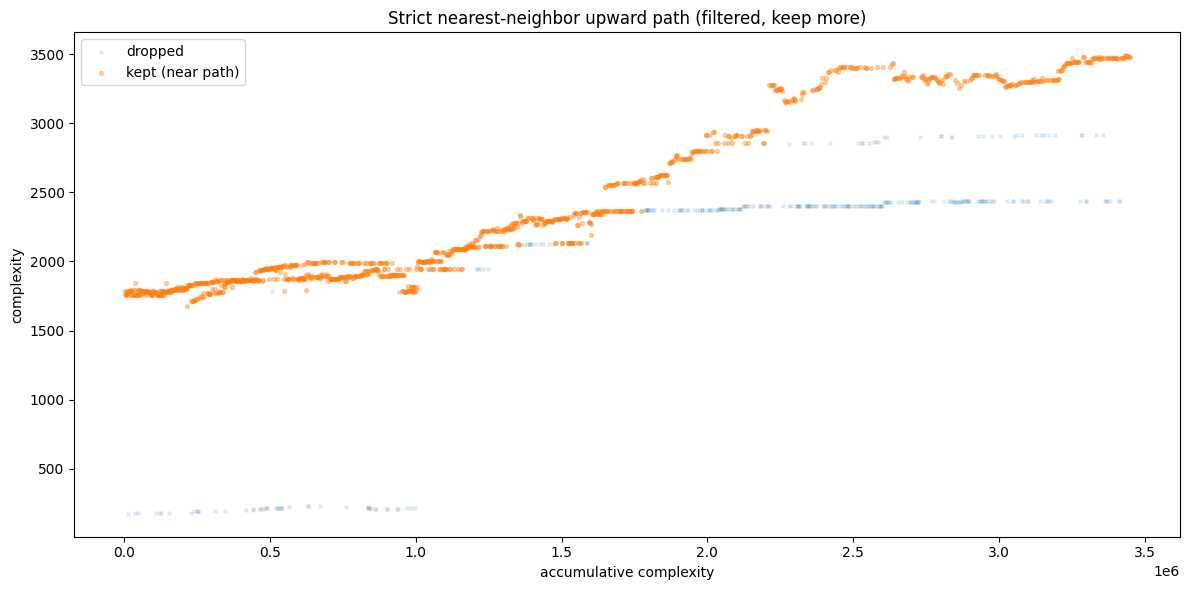

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def keep_more_points(x, y, x_path, y_path,
                     abs_tol=100.0,      # ÁªùÂØπÂÆπÂøçÔºà‚ÜëÊõ¥ÂÆΩÔºâ
                     rel_tol=0.012,      # Áõ∏ÂØπÂÆπÂøçÔºàÊåâË∑ØÂæÑÈ´òÂ∫¶ÊØî‰æãÔºõ‚ÜëÊõ¥ÂÆΩÔºâ
                     k_mad=2.0,          # Â±ÄÈÉ®Á®≥ÂÅ•Ê≥¢Âä®ÊùÉÈáçÔºà‚ÜëÊõ¥ÂÆΩÔºâ
                     q_low=15,           # ÂàÜÁÆ±‰ΩéÂàÜ‰ΩçÂÖúÂ∫ïÔºà‚ÜìÊõ¥ÂÆΩÔºõÂ¶Ç 10Ôºâ
                     jump_min=60.0,      # ËØÜÂà´‚ÄúÂè∞Èò∂Ë∑≥Âçá‚ÄùÁöÑÈòàÂÄº
                     jump_bonus=80.0,    # Âè∞Èò∂ÈôÑËøëÈ¢ùÂ§ñÊîæÂÆΩÔºà‚ÜëÊõ¥ÂÆΩÔºâ
                     x_radius_frac=0.03, # Âè∞Èò∂ÂΩ±ÂìçÂçäÂæÑÔºàÂç† x ËåÉÂõ¥ÊØî‰æãÔºõ‚ÜëÊõ¥ÂÆΩÔºâ
                     max_drop_cap=220.0  # ÂÖÅËÆ∏Âêë‰∏ãÊúÄÂ§ß‰∏ãÊé¢Ôºà‚ÜëÊõ¥ÂÆΩÔºâ
                    ):
    x = np.asarray(x); y = np.asarray(y)
    x_path = np.asarray(x_path); y_path = np.asarray(y_path)

    # Ë∑ØÂæÑÊåâ x ÈÄíÂ¢û
    order = np.argsort(x_path)
    x_path = x_path[order]; y_path = y_path[order]

    # Ë∑ØÂæÑÊèíÂÄºÔºàË£ÅÂâ™Âà∞Ë∑ØÂæÑËåÉÂõ¥ÔºåÈÅøÂÖçÁ´ØÁÇπÊ∞¥Âπ≥Â§ñÊé®Ôºâ
    x_min, x_max = x_path[0], x_path[-1]
    x_clip = np.clip(x, x_min, x_max)
    y_on_path = np.interp(x_clip, x_path, y_path)

    # ÊÆãÂ∑ÆÔºöÁÇπÁõ∏ÂØπË∑ØÂæÑÁöÑÈ´òÂ∫¶ÔºàË¥ü=Âú®Ë∑ØÂæÑ‰∏ãÊñπÔºâ
    r = y - y_on_path

    # ÂàÜÁÆ±ÂÅöÂ±ÄÈÉ®ÁªüËÆ°
    N = len(x)
    n_bins = max(20, min(120, N // 150))
    edges = np.linspace(x.min(), x.max(), n_bins + 1)
    bin_id = np.digitize(x, edges) - 1
    bin_id = np.clip(bin_id, 0, n_bins - 1)

    # Âü∫Á°ÄÈòàÂÄºÔºàË¥üÊï∞ÔºåË∂äË¥üË∂äÂÆΩÔºâ
    thr = -(abs_tol + rel_tol * y_on_path) * np.ones_like(y, float)

    # Âè†Âä† MAD Á®≥ÂÅ•Â∞∫Â∫¶
    for b in range(n_bins):
        idx = (bin_id == b)
        if idx.sum() < 15: 
            continue
        r_b = r[idx]
        med = np.median(r_b)
        mad = np.median(np.abs(r_b - med))
        sigma = 1.4826 * mad
        thr[idx] -= k_mad * sigma

    # ÂàÜÁÆ±‰ΩéÂàÜ‰ΩçÂÖúÂ∫ïÔºàÁ°Æ‰øùÊØèÁÆ±ÈÉΩÁïô‰∏ÄÊâπ‚ÄúÈù†ËøëÂπ≥Âè∞‚ÄùÁöÑÁÇπÔºâ
    for b in range(n_bins):
        idx = (bin_id == b)
        if idx.sum() < 15:
            continue
        r_b = r[idx]
        thr_q = np.percentile(r_b, q_low)
        thr[idx] = np.minimum(thr[idx], thr_q)

    # Âè∞Èò∂Ë∑≥ÂçáÈôÑËøëÈ¢ùÂ§ñÊîæÂÆΩÔºàÁÖßÈ°æÊñ∞Âπ≥Âè∞Áï•‰Ωé‰∫éÁ∫¢Á∫øÁöÑÁ∞áÔºâ
    dy = np.diff(y_path)
    jump_idx = np.where(dy >= jump_min)[0] + 1
    jump_x = x_path[jump_idx]
    x_radius = x_radius_frac * (x.max() - x.min())

    bonus = np.zeros_like(y, float)
    for jx in jump_x:
        near = np.abs(x - jx) <= x_radius
        bonus[near] += jump_bonus
    thr -= bonus

    # ÊúÄÂ§ß‰∏ãÊé¢‰øùÊä§
    thr = np.maximum(thr, -max_drop_cap)

    mask_keep = r >= thr
    return mask_keep, y_on_path

# ===== Áõ¥Êé•‰ΩøÁî®ÔºàÊé®Ëçê Balanced Ê°£Ôºâ=====
# ‰∏â‰∏™È¢ÑËÆæÔºö
presets = {
    "Conservative": dict(abs_tol=60,  rel_tol=0.008, k_mad=1.5, q_low=20, jump_min=60, jump_bonus=40, x_radius_frac=0.025, max_drop_cap=160),
    "Balanced":     dict(abs_tol=100, rel_tol=0.012, k_mad=2.0, q_low=15, jump_min=60, jump_bonus=80, x_radius_frac=0.03,  max_drop_cap=220),
    "Generous":     dict(abs_tol=140, rel_tol=0.016, k_mad=2.5, q_low=10, jump_min=50, jump_bonus=100,x_radius_frac=0.035, max_drop_cap=280),
}

mask_keep, y_on_path = keep_more_points(x, y, x_path, y_path, **presets["Balanced"])

# ÂèØËßÜÂåñÔºàÂå∫ÂàÜ kept / droppedÔºâ
idx = np.argsort(x)
plt.figure(figsize=(12,6))
plt.scatter(np.array(x)[~mask_keep], np.array(y)[~mask_keep], s=6, alpha=0.15, marker='x', label='dropped')
plt.scatter(np.array(x)[mask_keep],  np.array(y)[mask_keep],  s=8, alpha=0.35,              label='kept (near path)')
# plt.plot(np.array(x_path)[np.argsort(x_path)], np.array(y_path)[np.argsort(y_path)], lw=1.5, label='nearest upward path')
plt.xlabel('accumulative complexity'); plt.ylabel('complexity')
plt.title('Strict nearest-neighbor upward path (filtered, keep more)')
plt.legend(); plt.tight_layout(); plt.show()


In [10]:
np.array(x)[mask_keep]

array([1.78752000e+03, 3.54576000e+03, 5.31810000e+03, ...,
       3.44103962e+06, 3.44451826e+06, 3.44799690e+06])

In [11]:
np.array(y)[mask_keep]

array([1787.52, 1758.24, 1772.34, ..., 3489.36, 3478.64, 3478.64])

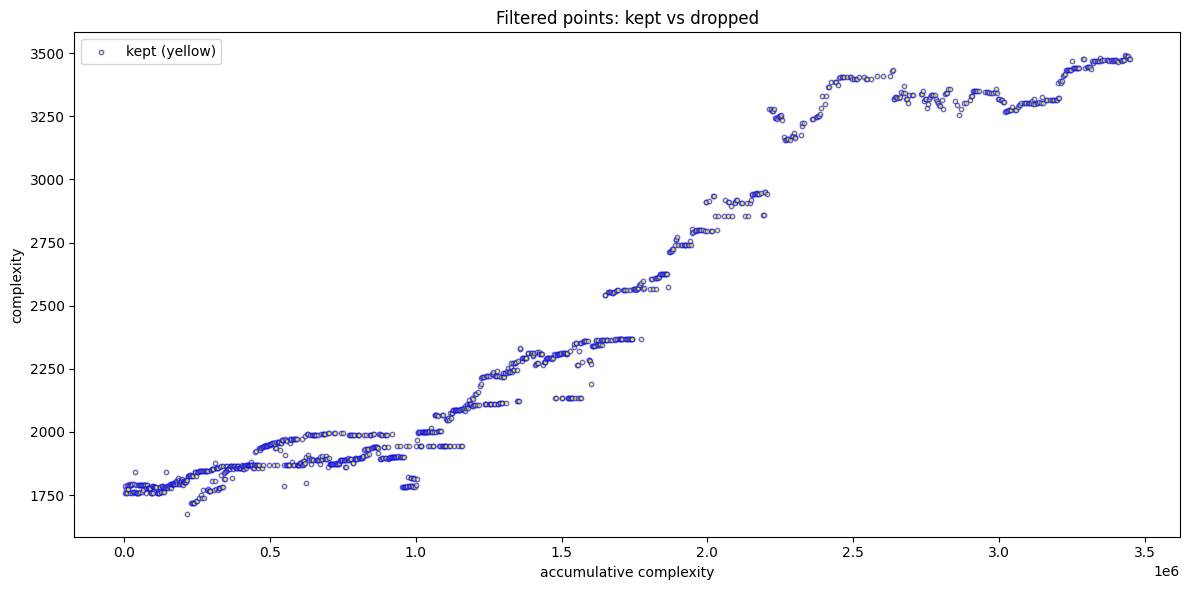

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ÈªÑËâ≤ÁÇπ
x_keep = np.array(x)[mask_keep]
y_keep = np.array(y)[mask_keep]

# Ë¢´‰∏¢ÂºÉÁöÑÁÇπ
x_drop = np.array(x)[~mask_keep]
y_drop = np.array(y)[~mask_keep]

plt.figure(figsize=(12,6))


# Áîª‰øùÁïôÁÇπÔºàÈªÑËâ≤Ôºâ
plt.scatter(x_keep, y_keep, s=10, alpha=0.6, color='yellow', edgecolors='blue', label='kept (yellow)')

plt.xlabel("accumulative complexity")
plt.ylabel("complexity")
plt.title("Filtered points: kept vs dropped")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
def fit_model(X, Y, m, cv_splits=5, random_state=42, is_fast=False):
    """ÊãüÂêà m ÊÆµÂπ∂ËÆ°ÁÆóÂêÑÁ±ªÊåáÊ†á"""
    mdl = pwlf.PiecewiseLinFit(X, Y)
    if is_fast == False:
        breaks = mdl.fit(m) 
    else: 
        breaks = mdl.fastfit(m) 
    y_hat = mdl.predict(X)

    n   = len(Y)
    rss = float(np.sum((Y - y_hat)**2))
    mse = rss / n 
    mae = float(mean_absolute_error(Y, y_hat)) #Mean Absolut Error 
    tss = float(np.sum((Y - np.mean(Y))**2)) #Total Sum of Squares, TSS
    r2  = 1 - rss / tss if tss > 0 else np.nan

    # ÂèÇÊï∞‰∏™Êï∞ÊÉ©ÁΩöÔºöÂ∏∏Áî®Ëøë‰ºº k = 2*mÔºàÊñúÁéá/Êà™Ë∑ù + Êñ≠ÁÇπËá™Áî±Â∫¶Ôºâ
    k   = 2 * m
    aic = n * np.log(mse) + 2 * k #Âú®‰øùËØÅÊ®°ÂûãÊãüÂêàÊï∞ÊçÆÁöÑÂêåÊó∂ÔºåÂ∞ΩÈáèÈÅøÂÖçÊ®°ÂûãËøá‰∫éÂ§çÊùÇÔºàoverfittingÔºâ„ÄÇ
    bic = n * np.log(mse) + k * np.log(n) #Âú®ÊãüÂêàÊïàÊûúÂíåÊ®°ÂûãÂ§çÊùÇÂ∫¶‰πãÈó¥ÂÅöÊùÉË°°Ôºå‰ΩÜ ÊØî AIC ÊÉ©ÁΩöÊõ¥‰∏•Ê†º„ÄÇ
    r2_adj = 1 - ((rss/(n - k)) / (tss/(n - 1))) if (n - k) > 0 and (tss > 0) else np.nan

#     # ‰∫§ÂèâÈ™åËØÅ MSE
#     kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
#     cv_mses = []
#     for tr, te in kf.split(X):
#         Xtr, Ytr = X[tr], Y[tr]
#         Xte, Yte = X[te], Y[te]
#         mdl_cv = pwlf.PiecewiseLinFit(Xtr, Ytr)
#         mdl_cv.fit(m)
#         Ypred = mdl_cv.predict(Xte)
#         cv_mses.append(mean_squared_error(Yte, Ypred))
#     cv_mse = float(np.mean(cv_mses))

    return {
        "m": m,
        "breaks": breaks,
        "train_MSE": mse,
        "train_MAE": mae,
        
        "R2": r2,
        "R2_adj": r2_adj,
        "AIC": aic,
        "BIC": bic,
#         "CV_MSE": cv_mse,
    }

In [19]:
def evaluate_all_segments(X, Y, min_m=2, max_m=40, criterion="BIC",
                          cv_splits=5, random_state=42, early_stop=True, is_fast=False):
    """
    ÈÅçÂéÜÂàÜÊÆµÊï∞ÔºåËøîÂõûÊØè‰∏™ m ÁöÑÊåáÊ†áÔºåÂπ∂Ê†πÊçÆ criterion ÈÄâÊúÄ‰Ω≥„ÄÇ
    criterion ‚àà {"BIC","AIC","CV_MSE","R2_adj","MSE"}
      - MSE Ë∂äÂ∞èË∂äÂ•ΩÔºàMSE ÊåáËÆ≠ÁªÉÈõÜ MSEÔºåÂØπÂ∫îÈîÆ‰∏∫ 'train_MSE'Ôºâ
      - R2_adj Ë∂äÂ§ßË∂äÂ•Ω
    """
    X = np.asarray(X).reshape(-1)
    Y = np.asarray(Y).reshape(-1)
    n = len(Y)

    # Âü∫Êú¨ÂèØË°åÊÄßÈôêÂà∂ÔºöËá≥Â∞ë‰øùËØÅÊØèÊÆµÊúâ‚â•2‰∏™ÁÇπÔºà‰øùÂÆà‰∫õÔºâ
    max_feasible = max(min(max_m, n // 2), min_m)
    ms = list(range(min_m, max_feasible + 1))

    crit = criterion.upper()
    # Â∞Ü "MSE" Áªü‰∏ÄÊò†Â∞ÑÂà∞ÁªìÊûú dict ‰∏≠ÁöÑÈîÆÂêç
    metric_key = {"MSE": "train_MSE"}.get(crit, crit)

    results = []
    for m in ms:
        t0 = time.perf_counter()
        try:
            res = fit_model(X, Y, m, cv_splits=cv_splits, random_state=random_state, is_fast=is_fast)
            t1 = time.perf_counter()
            res["time_s"] = t1 - t0
            results.append(res)
            
        except Exception as e:
            t1 = time.perf_counter()
            # Ëã•Êüê‰∫õ m Âõ†Êï∞ÊçÆÂàÜÂ∏ÉÈóÆÈ¢òÊó†Ê≥ïÊãüÂêàÔºåËÆ∞ÂΩïÈîôËØØÂπ∂ÁªßÁª≠
            results.append({"m": m, "error": str(e), "time_s": float(t1 - t0)})

        # ÊèêÂâçÂÅúÊ≠¢ÈÇèËºØ ÔºàÂü∫ÊñºÊâÄÈÅ∏ criterionÔºâ
        if early_stop and len(results) >= 3:
            last_three = [r for r in results[-3:] if "error" not in r and metric_key in r]
            if len(last_three) == 3:
                v0, v1, v2 = [r[metric_key] for r in last_three]
                if crit in ("MSE"):
                    # Ë∂äÂ∞èË∂äÂ•ΩÔºöËã•ÈÄ£Á∫å‰∏âÊ¨°ÊåáÊ®ôÈÅûÂ¢ûÔºåË™™ÊòéÈñãÂßãÊÉ°ÂåñÔºåÂÅúÊ≠¢
                    if (v2 > v1) and (v1 > v0):
                        break
                elif crit == "R2_ADJ":
                    # Ë∂äÂ§ßË∂äÂ•ΩÔºöËã•ËøûÁª≠‰∏âÊ¨°ÊåáÊ†áÈÄíÂáèÔºåÂÅúÊ≠¢
                    if (v2 < v1) and (v1 < v0):
                        break

    # ÈÄâÊúÄ‰ºò
    valid = [r for r in results if "error" not in r]
    if not valid:
        raise RuntimeError("Ê≤°ÊúâÊàêÂäüÁöÑÊãüÂêàÁªìÊûúÔºåËØ∑Ê£ÄÊü•Êï∞ÊçÆÊàñÊîæÂÆΩÂèØË°åËåÉÂõ¥„ÄÇ")

    if crit in ("MSE"):
        # Ë∂äÂ∞èË∂äÂ•ΩÔºõNaN/Áº∫Â§±Êó∂‰∏¢Âà∞ +‚àû
        def safe_val(r):
            v = r.get(metric_key, np.inf)
            return v if (v is not None and not np.isnan(v)) else np.inf
        best = min(valid, key=safe_val)

    # ÊâìÂç∞ÊëòË¶Å
    print("=== Summary ===")
    for r in valid:
        print(f"m={r['m']:>2} | "
              f"MSE={r['train_MSE']:.3f} | "
              f"time={r['time_s']:.2f} s | "
              f"breaks={np.round(r['breaks'],3)}"
             
             )
        print("--------------------------")
    shown_key = metric_key 
    print(f"\n‚úÖ Best by {criterion}: Segments(m)={best['m']}, MSE={best[shown_key]:.3f}, time:{best['time_s']:.2f}, breaks={np.round(best['breaks'], 6)}")
    return {"all": results, "best": best}

In [37]:
min_s = 20
max_s = 20
results = evaluate_all_segments(x_keep, y_keep, min_m=min_s, max_m=max_s, criterion="MSE",is_fast=False)

=== Summary ===
m=20 | MSE=2035.122 | time=893.97 s | breaks=[1.78752000e+03 2.65944590e+05 4.66752079e+05 9.24721030e+05
 9.91894410e+05 1.00703519e+06 1.29322442e+06 1.41682447e+06
 1.44039402e+06 1.53178848e+06 1.91919990e+06 1.99703373e+06
 2.20999712e+06 2.21212404e+06 2.25109546e+06 2.30547763e+06
 2.43971444e+06 2.79328198e+06 2.87307415e+06 3.06465836e+06
 3.44799690e+06]
--------------------------

‚úÖ Best by MSE: Segments(m)=20, MSE=2035.122, time:893.97, breaks=[1.78752000e+03 2.65944590e+05 4.66752079e+05 9.24721030e+05
 9.91894410e+05 1.00703519e+06 1.29322442e+06 1.41682447e+06
 1.44039402e+06 1.53178848e+06 1.91919990e+06 1.99703373e+06
 2.20999712e+06 2.21212404e+06 2.25109546e+06 2.30547763e+06
 2.43971444e+06 2.79328198e+06 2.87307415e+06 3.06465836e+06
 3.44799690e+06]


In [38]:
# Extract the "best" result (with chosen m)
best_result = results['best']
# Get the breakpoints array
breakpoints = best_result['breaks']

# print("Breakpoints as array:", breakpoints)
print("Breakpoints as Python list:", breakpoints.tolist())

Breakpoints as Python list: [1787.52, 265944.5898850784, 466752.0794282755, 924721.0302088183, 991894.4098824898, 1007035.1922151273, 1293224.4169830577, 1416824.467636866, 1440394.0188045371, 1531788.4800234903, 1919199.8995608243, 1997033.726468515, 2209997.1213130583, 2212124.0383289875, 2251095.4647904527, 2305477.6316385726, 2439714.4402623647, 2793281.9783359217, 2873074.1479346287, 3064658.3567613633, 3447996.899999999]


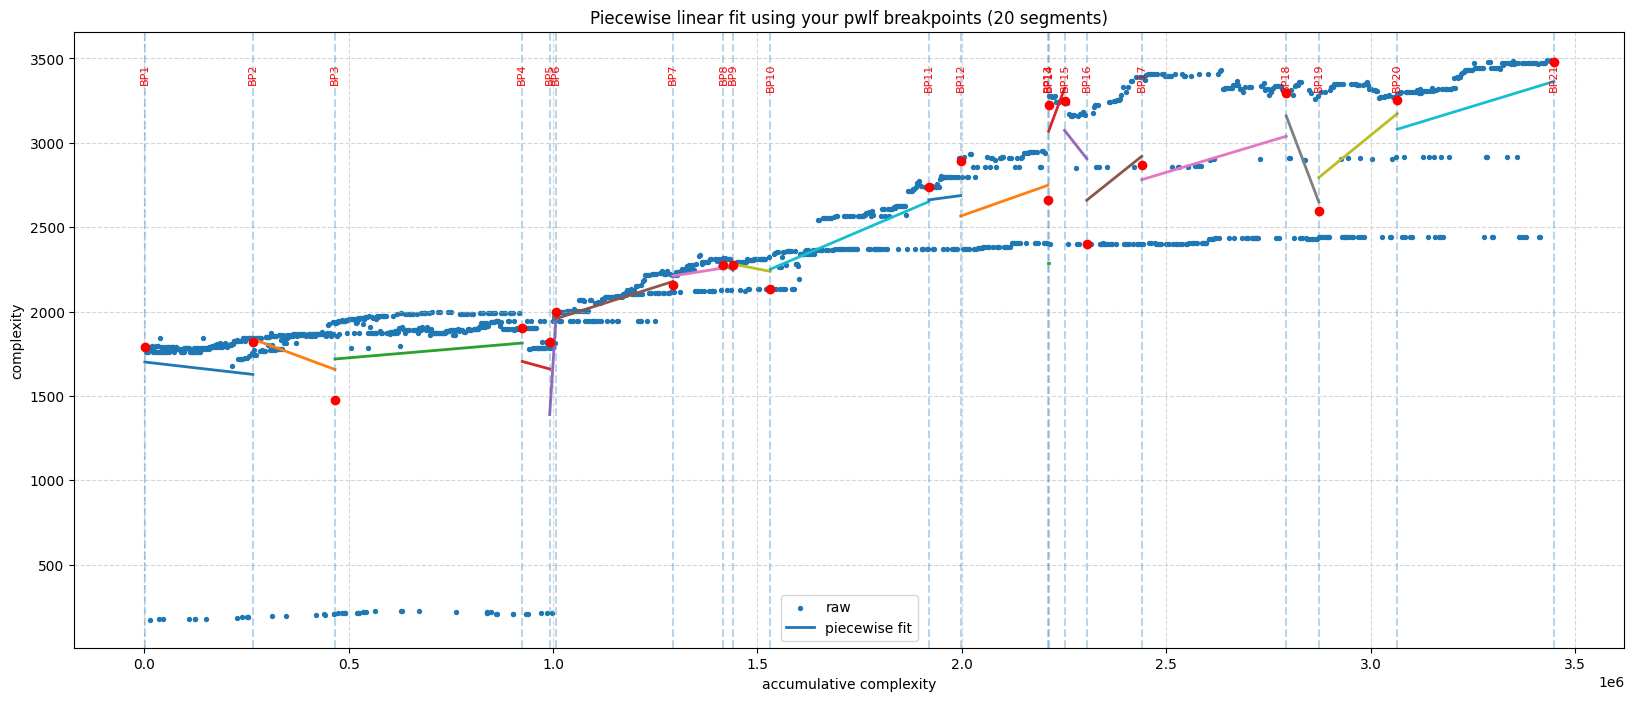

In [39]:
plt.figure(figsize=(20, 8))
plt.scatter(x, y, s=8, label='raw')

requested_segments = len(breakpoints) - 1

for i in range(len(breakpoints) - 1):
    x0, x1 = breakpoints[i], breakpoints[i+1]
    mask = (x >= x0) & ((x < x1) if i < len(breakpoints)-2 else (x <= x1))
    Xi, Yi = x[mask], y[mask]

    if Xi.size >= 2:
        X1 = np.vstack([np.ones_like(Xi), Xi]).T
        beta, *_ = np.linalg.lstsq(X1, Yi, rcond=None)
        a, b = beta
        xs = np.linspace(x0, x1, 200)
        ys = a + b*xs
    elif Xi.size == 1:
        xs = np.linspace(x0, x1, 200)
        ys = np.full_like(xs, Yi.item())
    else:
        xs = np.linspace(x0, x1, 200)
        ys = np.full_like(xs, y.mean())
    
    plt.plot(xs, ys, linewidth=2, label='piecewise fit' if i==0 else None)

# --- draw vertical lines and annotate breakpoints ---
for j, bp in enumerate(breakpoints):
    plt.axvline(bp, linestyle='--', alpha=0.3)
    # mark point on axis
    plt.scatter(bp, np.interp(bp, x, y), color='red', zorder=5)
    # label
    plt.text(bp, plt.ylim()[1]*0.95, f'BP{j+1}', rotation=90,
             va='top', ha='center', fontsize=8, color='red')

plt.title(f'Piecewise linear fit using your pwlf breakpoints ({requested_segments} segments)')
plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()